In [10]:
import numpy as np
import matplotlib.pyplot as plt

Reading in 1000 segmented waveforms from the oscilloscope:

In [6]:
data = np.genfromtxt(r"C:\Users\louis\OneDrive\Documents\University of Manchester\Physics\Year 4\MPhys\data\Run 2.csv", delimiter=',', skip_header=3)

In [9]:
waveforms = np.zeros((640,3,1000))

for i in range(1000):
    waveforms[:,:,i] = data[i*640:(i+1)*640,:]

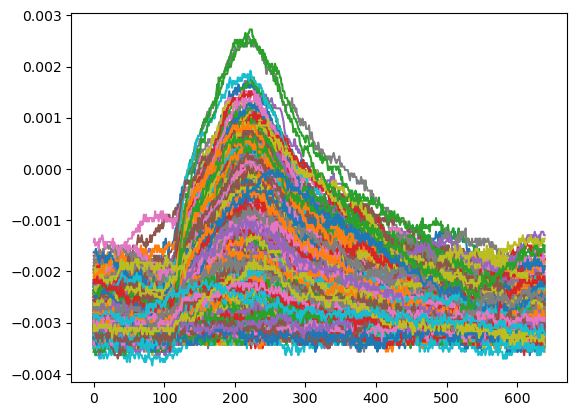

In [25]:
for i in range(1000):
    plt.plot(waveforms[:,1,i])
    #plt.ylim(-0.004,-0.002)

plt.savefig(r"C:\Users\louis\OneDrive\Documents\University of Manchester\Physics\Year 4\MPhys\mphys-lab-book\waveform_plot_101024.jpg")


In [ ]:
def determine_roi(all_waveforms, plot=False):
    """Determine the Region of Interest (ROI).  Locate the common peak in all waveforms 
    and the beginning of integration region.  An end value for the ROI is provided but is later 
    discarded.

    Parameters
    ----------
    all_waveforms : list of 2d np arrays
        list with each entry being a 2d np array describing a waveform with columns (time, amplitude)
    plot : bool, optional
        plot the determined roi or not, by default False

    Returns
    -------
    int, int, int
        indices of begin of ROI, end of ROI, location of peak
    """
    time = []
    amplitude = []
    bins = len(all_waveforms[0])
    
    print("Determining ROI...")
    for index, waveform in tqdm(enumerate(all_waveforms)):
        for index_inner, single_point in enumerate(waveform):
            time.append(single_point[0])
            amplitude.append(single_point[1])
    
    smallest = np.min(amplitude)
    amplitude = amplitude + np.abs(smallest)

    time = np.array(time)
    time *= 10**9

    hist, edges = np.histogram(time, bins, weights=amplitude)
    plot1d(hist, edges, alpha= 0.2, label='raw signal')
    hist_filtered = savgol_filter(hist, 60, 9)
    hist_deriv = savgol_filter(hist, 60, 9, 1, edges[1] - edges[0])
    visual_extrema = np.where(np.abs(hist_deriv) <= np.max(hist_deriv)/30, hist_filtered, np.full(np.shape(hist), np.nan))
    plot1d(hist_filtered, edges, alpha = 0.2, color='r', label='smoothed signal')
    #plt.scatter(get_bin_centres(edges), visual_extrema,  color='r')
    
    numerical_extrema = np.where(np.isnan(visual_extrema) , np.zeros(np.shape(visual_extrema)), visual_extrema)
    
    max_loc = np.argmax(numerical_extrema)
    plt.scatter(get_bin_centres(edges)[max_loc], visual_extrema[max_loc], color='r')
    #print(visual_extrema[max_loc])

    #define some dummy variables to find the peak before 
    iterator = max_loc
    activate = False
    roi_begin = 0

    while iterator >= 0:

        if(numerical_extrema[iterator] == 0):
            activate = True
        
        else:
            if activate == True:
                roi_begin = iterator
                break


        iterator -= 1


    plt.scatter(get_bin_centres(edges)[roi_begin], visual_extrema[roi_begin], color='r')

    #For the upper ROI limit just take 3 times the 
    diff = max_loc - roi_begin
    roi_end = max_loc + 1 * diff
    

    #plt.scatter(get_bin_centres(edges)[roi_end], hist_filtered[roi_end], color='r')
    plt.xlabel("time[ns]", fontsize = 18)
    plt.ylabel("Summed signal[V]", fontsize = 18)
    #plt.title("ROI determination")
    plt.legend(fontsize=18)
    plt.tick_params(axis='both', labelsize=16)
    plt.tight_layout()
    

    if plot==True:
        #plt.savefig("PLOTS_FOLDER + ROI_example_sipm.png", dpi=600)
        plt.show()
    plt.cla()
    print("ROI determined to be [{0}:{1}]".format(roi_begin, roi_end))

    return roi_begin, roi_end, max_loc